データサイエンス特別PG データサイエンス特論 第12回 課題

In [1]:
# google colab で実行する場合は下記のコメントアウトを外して実行する
# ! wget https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx
# ! pip install japanize-matplotlib
# ! pip install kneed

In [49]:
import os
import psutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import openpyxl
import pandas as pd
import datetime
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator, DataGenerator
import seaborn as sns

In [26]:
# 論理コア（logical cores）の数を取得し、環境変数に設定
# https://relaxing-living-life.com/1831/
def set_loky_max_cpu_count():
    physical_cores = psutil.cpu_count(logical=False)
    logical_cores = psutil.cpu_count(logical=True)
    cpu_count = max(1, min(physical_cores, logical_cores))
    os.environ['LOKY_MAX_CPU_COUNT'] = str(cpu_count)
    print(f"LOKY_MAX_CPU_COUNT set to {cpu_count}")
set_loky_max_cpu_count()

LOKY_MAX_CPU_COUNT set to 20


In [51]:
# 対象データを読み込み、データフレームに格納
weather_df = pd.read_excel('ds07_temp_power_exercise.xlsx', 
                           sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                           names=['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                           '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                           '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])

# 分析対象期間のデータを抽出
year = 2020
month = 7
data = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧'] 
target = '天気概況'
weather_data = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                        & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][data].values
weather_target = []
for _day, _target in enumerate(weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                                          & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][target].values):
    weather_target.append(f'{_target} ({year}/{month}/{_day+1})')
# データを標準化
stdsc = StandardScaler()
weather_data = stdsc.fit_transform(weather_data)

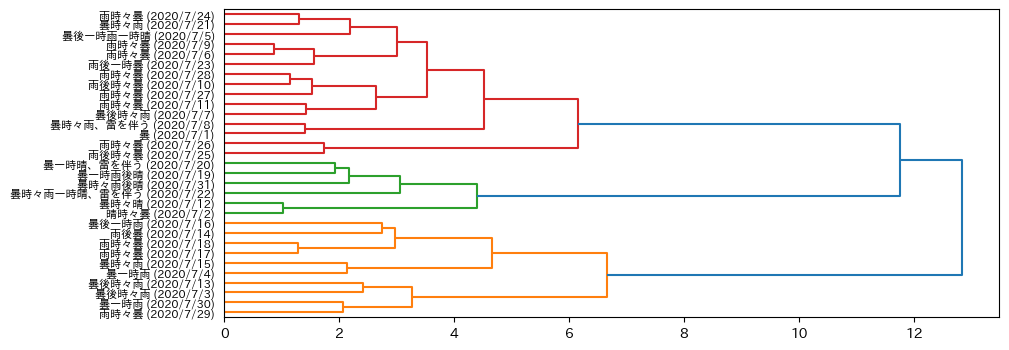

In [52]:
# 階層型クラスタリングのクラスター間の距離を計算 (ユークリッド距離を利用)
dist = hierarchy.distance.pdist(weather_data, metric='euclidean')
# クラスターを統合 (ward法)
linkage = hierarchy.linkage(dist, method='ward', metric='euclidean') 
# デンドログラムを表示
fig, ax = plt.subplots(figsize=(10,4))
ax = hierarchy.dendrogram(Z=linkage, orientation='right', labels=weather_target)

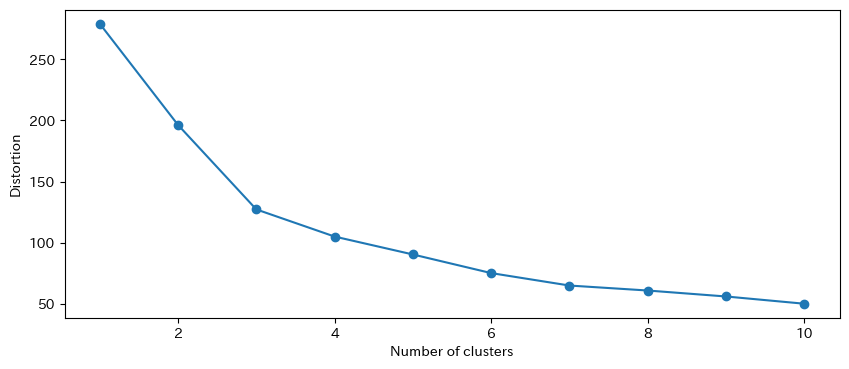

In [28]:
# クラスタ数を決定するために距離の総計を確認し、グラフを描画
distortions = []
for i  in range(1,11):
    km = KMeans(n_clusters=i, init='random', n_init='auto', max_iter=30, random_state=1)
    km.fit(weather_data)
    distortions.append(km.inertia_)

plt.figure(figsize=(10,4))
plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [29]:
# KneeLocator でエルボー法によるクラスタ数を決定
kneedle = KneeLocator(range(1,11), distortions, curve='convex', direction='decreasing')
print('elbow:', round(kneedle.elbow, 3))

elbow: 3


cluster 0 ['曇後時々雨 (2020/7/3)', '曇一時雨 (2020/7/4)', '曇後時々雨 (2020/7/13)', '雨後曇 (2020/7/14)', '曇時々雨 (2020/7/15)', '曇後一時雨 (2020/7/16)', '雨時々曇 (2020/7/17)', '雨時々曇 (2020/7/18)', '雨時々曇 (2020/7/29)', '曇一時雨 (2020/7/30)']
cluster 1 ['曇 (2020/7/1)', '曇後一時雨一時晴 (2020/7/5)', '雨時々曇 (2020/7/6)', '曇後時々雨 (2020/7/7)', '曇時々雨、雷を伴う (2020/7/8)', '雨時々曇 (2020/7/9)', '雨後時々曇 (2020/7/10)', '雨時々曇 (2020/7/11)', '曇時々雨 (2020/7/21)', '雨後一時曇 (2020/7/23)', '雨時々曇 (2020/7/24)', '雨後時々曇 (2020/7/25)', '雨時々曇 (2020/7/26)', '雨時々曇 (2020/7/27)', '雨時々曇 (2020/7/28)']
cluster 2 ['晴時々曇 (2020/7/2)', '曇時々晴 (2020/7/12)', '曇一時雨後晴 (2020/7/19)', '曇一時晴、雷を伴う (2020/7/20)', '曇時々雨一時晴、雷を伴う (2020/7/22)', '曇時々雨後晴 (2020/7/31)']


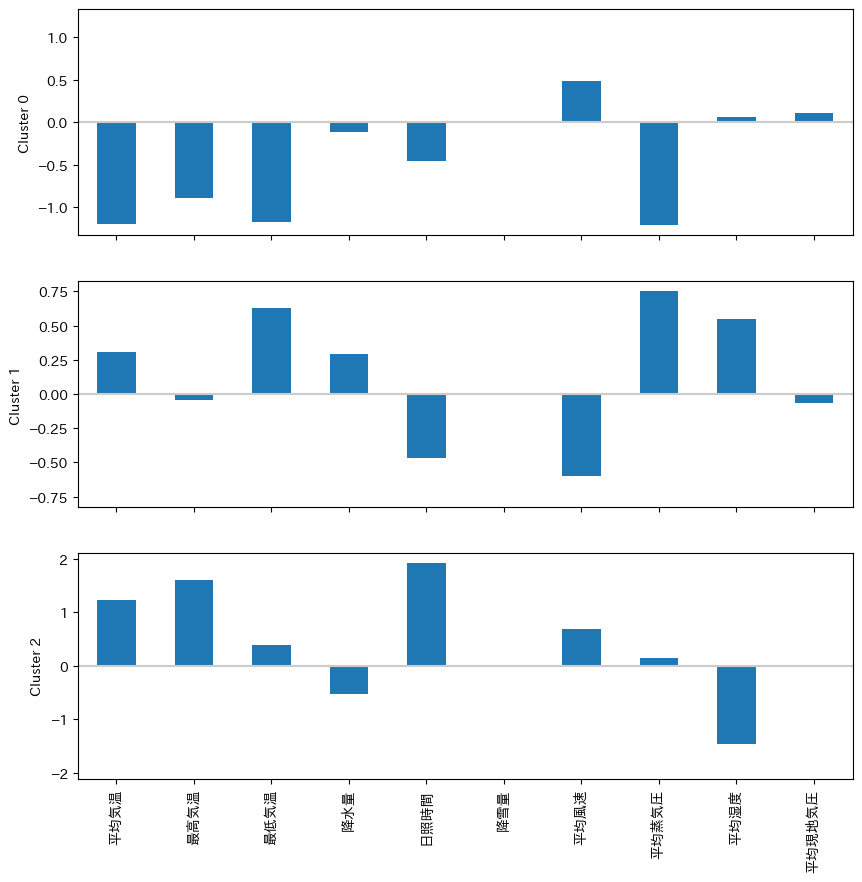

In [30]:
# クラスタ数を決めて、kmeans法でクラスタリング
_n_cluster = 3
kmeans = KMeans(n_clusters=_n_cluster, max_iter=30, n_init='auto', init="random", random_state=1)
cluster = kmeans.fit_predict(weather_data)

# 各クラスタの天気概況を確認
for i in range(_n_cluster):
    _weather_list = []
    for _cluster, _weather in zip(cluster, weather_target):
        if i == _cluster:
            _weather_list.append(_weather)
    print('cluster', i, _weather_list)

# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(10,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i}')
    ax.set_ylim(-maxPC, maxPC)

In [31]:
# 分析対象期間のデータを抽出
year = 2020
month = 8
data = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧'] 
target = '天気概況'
weather_data = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                        & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][data].values
weather_target = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                            & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][target].values

# データを標準化
stdsc = StandardScaler()
weather_data = stdsc.fit_transform(weather_data)

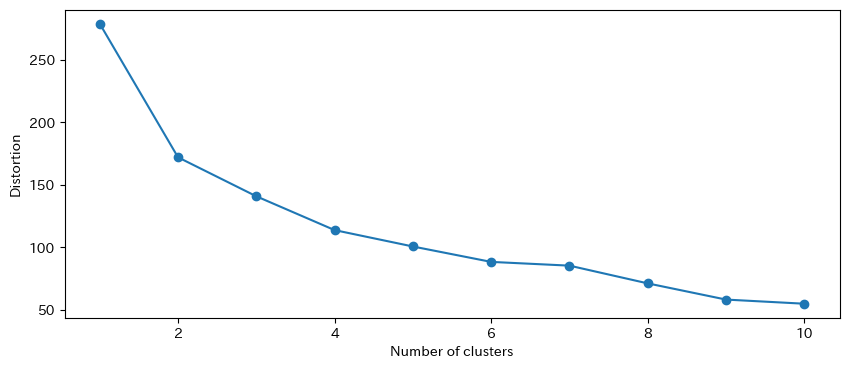

In [32]:
# クラスタ数を決定するために距離の総計を確認
distortions = []
for i  in range(1,11):
    km = KMeans(n_clusters=i, init='random', n_init='auto', max_iter=30, random_state=1)
    km.fit(weather_data)
    distortions.append(km.inertia_)

plt.figure(figsize=(10,4))
plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

cluster 0 ['晴一時曇', '晴時々曇', '曇時々晴', '曇時々晴', '曇時々晴', '曇時々晴', '晴', '晴後曇時々雨、雷を伴う', '晴時々曇、雷を伴う', '晴', '晴', '晴、雷を伴う', '晴時々曇、雷を伴う', '晴時々曇', '晴時々曇', '晴', '晴', '晴一時曇後一時雨', '曇時々晴一時雨、雷を伴う', '晴時々曇一時雨', '晴', '晴一時曇']
cluster 1 ['晴一時雨後曇', '曇時々晴', '晴時々曇', '曇', '曇時々晴一時雨、雷を伴う', '×', '雨時々曇後晴', '晴時々曇', '曇後一時晴']


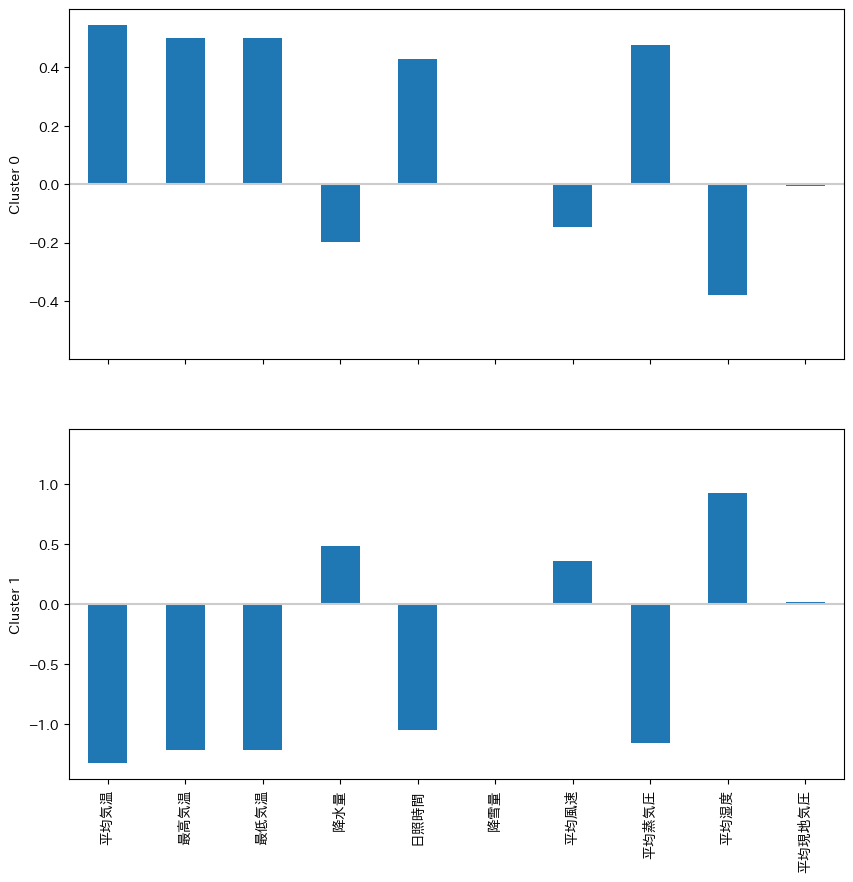

In [33]:
# クラスタ数を決めて、kmeans法でクラスタリング
_n_cluster = 2
kmeans = KMeans(n_clusters=_n_cluster, max_iter=30, n_init='auto', init="random", random_state=1)
cluster = kmeans.fit_predict(weather_data)

# 各クラスタの天気概況を確認
for i in range(_n_cluster):
    _weather_list = []
    for _cluster, _weather in zip(cluster, weather_target):
        if i == _cluster:
            _weather_list.append(_weather)
    print('cluster', i, _weather_list)

# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(10,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i}')
    ax.set_ylim(-maxPC, maxPC)

In [34]:
# 2020年の1年分のデータを対象にする
weather_data = weather_df[data].values
weather_target = weather_df[target].values
# データを標準化
stdsc = StandardScaler()
weather_data = stdsc.fit_transform(weather_data)

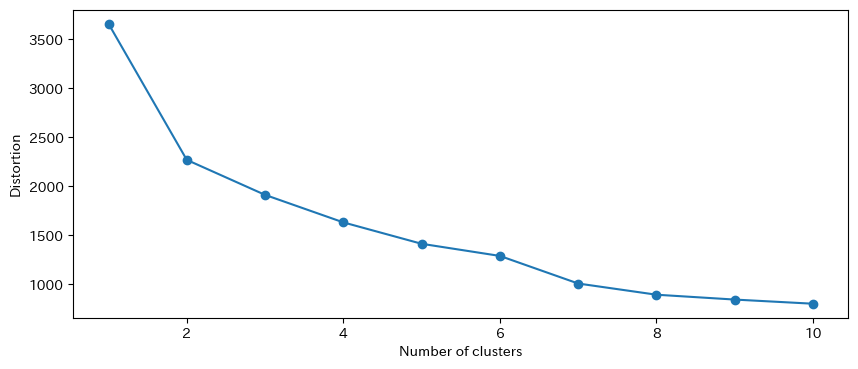

In [35]:
# クラスタ数を決定するために距離の総計を確認
distortions = []
for i  in range(1,11):
    km = KMeans(n_clusters=i, init='random', n_init='auto', max_iter=30, random_state=1)
    km.fit(weather_data)
    distortions.append(km.inertia_)

plt.figure(figsize=(10,4))
plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

cluster 0 195
cluster 1 171


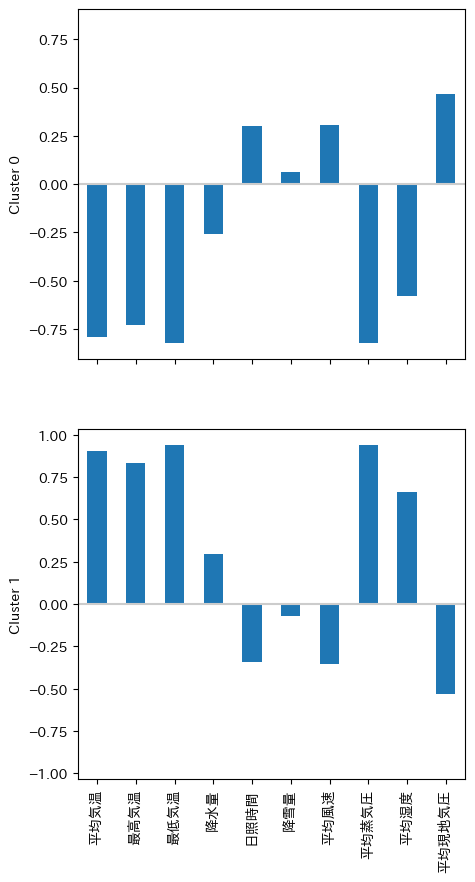

In [36]:
# クラスタ数を決めて、kmeans法でクラスタリング
_n_cluster = 2
kmeans = KMeans(n_clusters=_n_cluster, max_iter=30, n_init='auto', init="random", random_state=1)
cluster = kmeans.fit_predict(weather_data)

# 各クラスタの日数を確認
for i in range(_n_cluster):
    _day = 0
    for _cluster in cluster:
        if i == _cluster:
            _day = _day + 1
    print('cluster', i, _day)

# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(5,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i}')
    ax.set_ylim(-maxPC, maxPC)

For n_clusters = 2
The average silhouette_score is : 0.37951


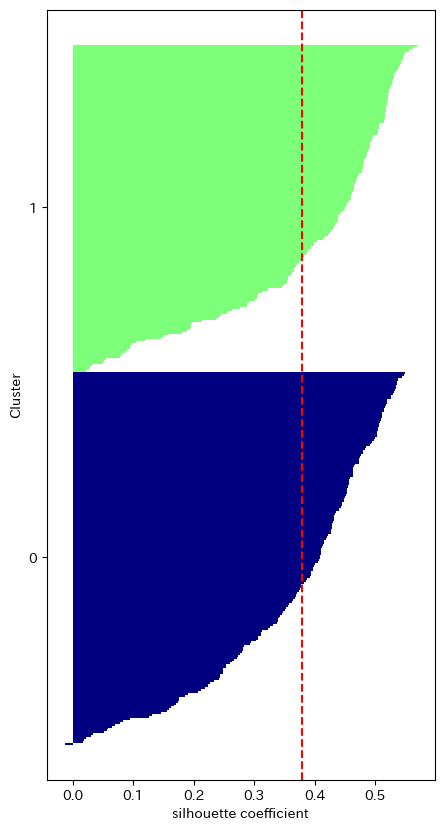

In [37]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2
# シルエット法によりクラスタリング結果を評価
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
cluster_labels = np.unique(cluster)
silhouette_avg = silhouette_score(weather_data, cluster, metric='euclidean')
print("For n_clusters =", _n_cluster)
print(f"The average silhouette_score is : {silhouette_avg:.05f}")
silhouette_values = silhouette_samples(weather_data, cluster, metric='euclidean')
y_ax_lower, y_ax_upper= 0,0
yticks = []
plt.figure(figsize=(5, 10))
for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_values[cluster==c] 
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/_n_cluster) 
        plt.barh(range(y_ax_lower,y_ax_upper),
                                c_silhouette_vals,
                                height=1.0,
                                edgecolor='none',
                                color=color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_values)
plt.axvline(silhouette_avg,color="red",linestyle="--")
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

cluster 0 98
cluster 1 156
cluster 2 112


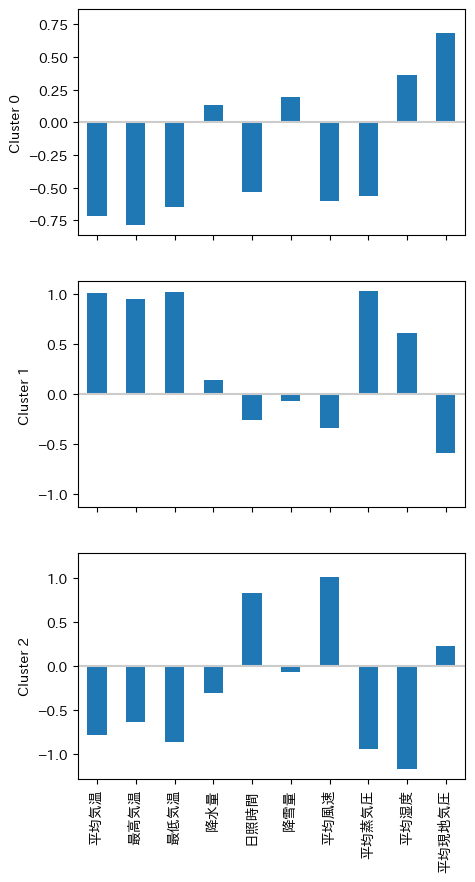

In [38]:
# クラスタ数を決めて、kmeans法でクラスタリング
_n_cluster = 3
kmeans = KMeans(n_clusters=_n_cluster, max_iter=30, n_init='auto', init="random", random_state=1)
cluster = kmeans.fit_predict(weather_data)

# 各クラスタの日数を確認
for i in range(_n_cluster):
    _day = 0
    for _cluster in cluster:
        if i == _cluster:
            _day = _day + 1
    print('cluster', i, _day)
    
# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(5,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i}')
    ax.set_ylim(-maxPC, maxPC)

For n_clusters = 3
The average silhouette_score is : 0.31858


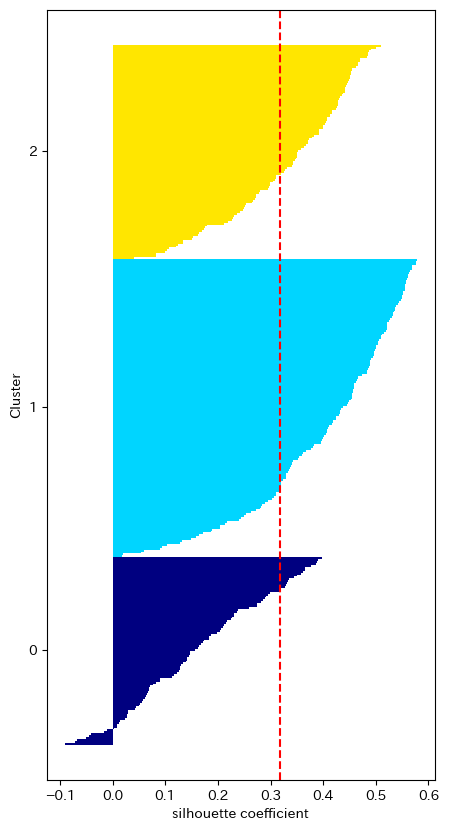

In [39]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2
# シルエット法によりクラスタリング結果を評価
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
cluster_labels = np.unique(cluster)
silhouette_avg = silhouette_score(weather_data, cluster, metric='euclidean')
print("For n_clusters =", _n_cluster)
print(f"The average silhouette_score is : {silhouette_avg:.05f}")
silhouette_values = silhouette_samples(weather_data, cluster, metric='euclidean')
y_ax_lower, y_ax_upper= 0,0
yticks = []
plt.figure(figsize=(5, 10))
for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_values[cluster==c] 
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/_n_cluster) 
        plt.barh(range(y_ax_lower,y_ax_upper),
                                c_silhouette_vals,
                                height=1.0,
                                edgecolor='none',
                                color=color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_values)
plt.axvline(silhouette_avg,color="red",linestyle="--")
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

cluster 0 146
cluster 1 89
cluster 2 106
cluster 3 25


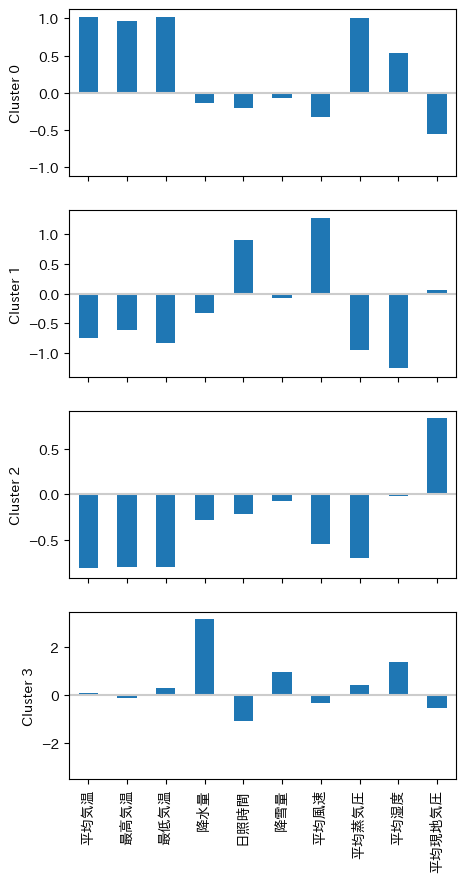

In [40]:
# クラスタ数を決めて、kmeans法でクラスタリング
_n_cluster = 4
kmeans = KMeans(n_clusters=_n_cluster, max_iter=30, n_init='auto', init="random", random_state=1)
cluster = kmeans.fit_predict(weather_data)

# 各クラスタの日数を確認
for i in range(_n_cluster):
    _day = 0
    for _cluster in cluster:
        if i == _cluster:
            _day = _day + 1
    print('cluster', i, _day)
    
# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(5,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i}')
    ax.set_ylim(-maxPC, maxPC)

For n_clusters = 4
The average silhouette_score is : 0.31996


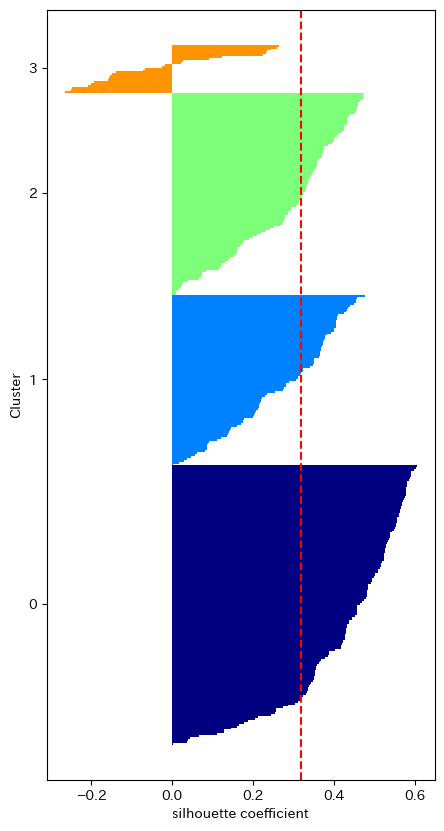

In [41]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2
# シルエット法によりクラスタリング結果を評価
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
cluster_labels = np.unique(cluster)
silhouette_avg = silhouette_score(weather_data, cluster, metric='euclidean')
print("For n_clusters =", _n_cluster)
print(f"The average silhouette_score is : {silhouette_avg:.05f}")
silhouette_values = silhouette_samples(weather_data, cluster, metric='euclidean')
y_ax_lower, y_ax_upper= 0,0
yticks = []
plt.figure(figsize=(5, 10))
for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_values[cluster==c] 
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/_n_cluster) 
        plt.barh(range(y_ax_lower,y_ax_upper),
                                c_silhouette_vals,
                                height=1.0,
                                edgecolor='none',
                                color=color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_values)
plt.axvline(silhouette_avg,color="red",linestyle="--")
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

cluster 0 2
cluster 1 41
cluster 2 81
cluster 3 52
cluster 4 13
cluster 5 76
cluster 6 101


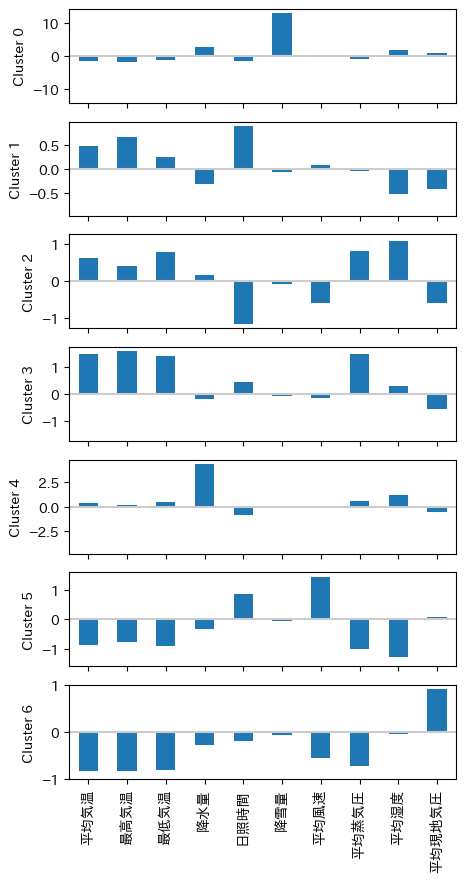

In [42]:
# クラスタ数を決めて、kmeans法でクラスタリング
_n_cluster = 7
kmeans = KMeans(n_clusters=_n_cluster, max_iter=30, n_init='auto', init="random", random_state=1)
cluster = kmeans.fit_predict(weather_data)

# 各クラスタの日数を確認
for i in range(_n_cluster):
    _day = 0
    for _cluster in cluster:
        if i == _cluster:
            _day = _day + 1
    print('cluster', i, _day)
    
# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(5,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i}')
    ax.set_ylim(-maxPC, maxPC)

In [43]:
# 各クラスタの天気概況を確認
for i in range(_n_cluster):
    _weather_list = []
    for _cluster, _weather in zip(cluster, weather_target):
        if i == _cluster:
            _weather_list.append(_weather)
    print('cluster', i, f'({len(_weather_list)})', _weather_list)

cluster 0 (2) ['雨時々みぞれ', 'みぞれ時々雨一時曇']
cluster 1 (41) ['晴', '晴後一時雨', '晴', '晴', '曇時々晴', '曇時々晴', '晴後一時曇', '晴', '晴', '晴時々曇', '晴', '曇時々晴', '晴後雨時々曇', '晴時々曇', '晴一時曇', '晴、雷を伴う', '晴後一時曇', '曇時々晴', '晴', '曇一時雨後晴', '曇後時々晴', '曇時々晴一時雨', '晴時々曇、雷を伴う', '晴', '晴後時々曇、雷を伴う', '晴時々曇', '曇一時雨後晴', '晴', '晴後一時曇', '晴', '晴後時々曇', '晴後時々曇', '晴', '晴', '晴', '曇時々晴', '晴一時雨', '晴時々曇', '晴', '晴時々曇', '曇時々晴']
cluster 2 (81) ['曇時々雨', '雨', '曇時々晴後雨', '雨', '曇時々雨', '雨時々曇、雷を伴う', '曇時々雨一時晴', '曇後一時晴', '雨時々曇', '曇後時々雨', '曇時々雨', '曇一時雨', '曇時々雨', '曇時々雨', '曇後時々雨', '曇時々雨', '曇後時々雨', '曇後一時雨', '雨', '曇時々雨', '雨時々曇', '雨時々曇一時晴', '曇', '曇時々雨', '曇後一時雨一時晴', '雨時々曇', '曇', '曇後時々雨', '曇一時雨', '曇後一時雨一時晴', '雨時々曇', '曇後時々雨', '曇時々雨、雷を伴う', '雨時々曇', '雨後時々曇', '雨時々曇', '曇後時々雨', '雨後曇', '曇時々雨', '曇後一時雨', '雨時々曇', '雨時々曇', '曇時々雨', '雨後一時曇', '雨時々曇', '雨時々曇', '雨時々曇', '雨時々曇', '雨時々曇', '曇一時雨', '曇時々雨後晴', '曇時々雨', '曇時々雨一時晴、雷を伴う', '雨後曇時々晴、雷を伴う', '曇時々雨', '曇後時々雨', '曇一時晴', '曇一時晴', '曇時々雨一時晴', '曇後一時雨', '曇後時々雨', '雨時々曇', '曇時々雨', '曇後晴', '雨時々曇', '曇時々雨', '雨', '雨時々曇', '曇後一時雨一時晴、雷を伴う', '曇', '曇一時雨後時々晴

For n_clusters = 7
The average silhouette_score is : 0.28383


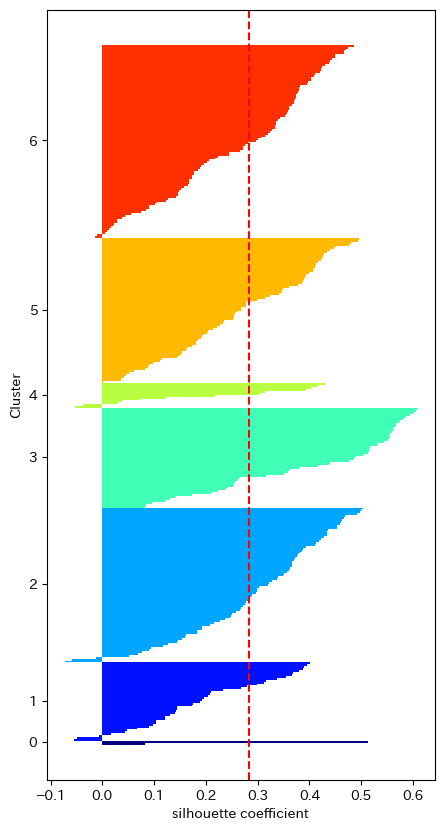

In [44]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2
# シルエット法によりクラスタリング結果を評価
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
cluster_labels = np.unique(cluster)
silhouette_avg = silhouette_score(weather_data, cluster, metric='euclidean')
print("For n_clusters =", _n_cluster)
print(f"The average silhouette_score is : {silhouette_avg:.05f}")
silhouette_values = silhouette_samples(weather_data, cluster, metric='euclidean')
y_ax_lower, y_ax_upper= 0,0
yticks = []
plt.figure(figsize=(5, 10))
for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_values[cluster==c] 
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/_n_cluster) 
        plt.barh(range(y_ax_lower,y_ax_upper),
                                c_silhouette_vals,
                                height=1.0,
                                edgecolor='none',
                                color=color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_values)
plt.axvline(silhouette_avg,color="red",linestyle="--")
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

cluster 0 18
cluster 1 24
cluster 2 161
cluster 3 65
cluster 4 2
cluster 5 21
cluster 6 75


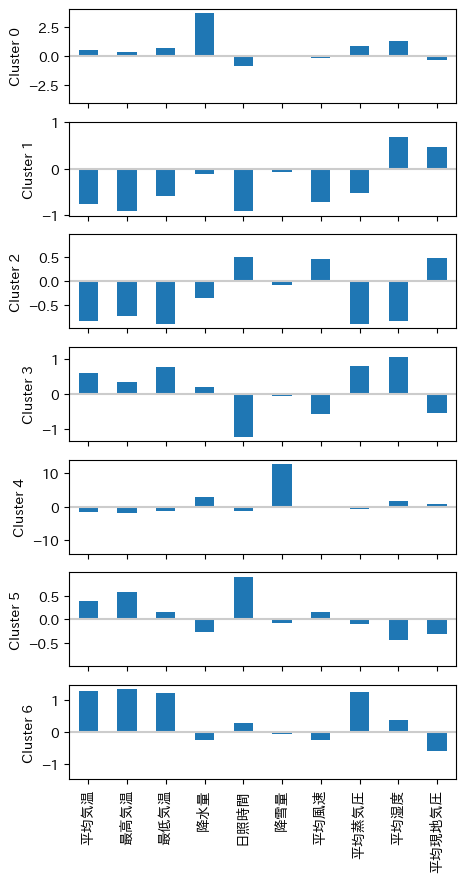

In [45]:
# 混合カウスモデルでクラスタリングを実行
_n_cluster = 7
clf = GaussianMixture(n_components=_n_cluster)
cluster = clf.fit_predict(weather_data)

# 各クラスタの日数を確認
for i in range(_n_cluster):
    _day = 0
    for _cluster in cluster:
        if i == _cluster:
            _day = _day + 1
    print('cluster', i, _day)

# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(clf.means_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(5,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i}')
    ax.set_ylim(-maxPC, maxPC)

In [46]:
# 各クラスタの天気概況を確認
for i in range(_n_cluster):
    _weather_list = []
    for _cluster, _weather in zip(cluster, weather_target):
        if i == _cluster:
            _weather_list.append(_weather)
    print('cluster', i, f'({len(_weather_list)})', _weather_list)

cluster 0 (18) ['晴一時雨', '大雨、雷を伴う', '大雨後一時晴、雷を伴う', '雨後時々曇', '曇後一時大雨、雷を伴う', '大雨', '大雨後曇時々晴', '雨後時々曇', '雨時々曇', '曇時々晴一時雨、雷を伴う', '曇時々雨一時晴、雷を伴う', '曇時々雨、雷を伴う', '晴一時曇後一時大雨、雷を伴う', '晴後一時雨、雷を伴う', '雨', '雨一時曇', '雨', '雨']
cluster 1 (24) ['曇一時晴後雨', '雨後曇時々晴', '雨後曇時々晴', '雨一時みぞれ後曇', '曇', '曇時々雨', '曇時々雨', '晴', '曇時々晴後雨', '雨後曇', '雨後一時曇', '雨時々曇', '雨一時曇、みぞれを伴う', '曇一時雨', '雨時々曇', '曇時々晴、雷を伴う', '曇後一時雨', '曇時々雨', '曇時々晴', '曇後時々雨', '曇時々晴', '曇時々雨', '曇時々雨一時晴', '雨時々曇']
cluster 2 (161) ['晴', '晴', '晴', '晴', '晴', '晴後一時曇', '晴', '晴後一時曇', '曇後晴', '曇一時晴後雨', '晴', '晴後時々曇', '晴一時曇', '曇時々晴', '曇一時雪後みぞれ時々雨', '晴後一時曇', '晴', '晴', '曇時々晴', '晴一時曇', '曇時々晴', '曇後一時晴', '晴', '晴', '晴', '晴', '晴時々曇', '晴時々曇', '晴後時々曇', '晴一時曇', '晴', '晴', '晴', '晴時々曇', '晴', '晴時々曇', '曇一時雨後晴', '曇一時晴後一時雨', '曇', '晴', '晴', '曇時々晴', '曇後時々晴', '晴', '晴一時曇', '晴', '晴時々曇', '曇時々晴', '晴時々曇', '晴', '曇時々雨', '雨時々曇後晴', '晴', '曇', '晴時々曇', '晴', '晴', '曇時々晴', '晴後一時雨一時曇', '晴時々曇一時雨', '晴', '晴一時雨', '晴', '晴一時曇', '晴', '晴後一時雨', '晴時々曇', '晴一時雨、みぞれを伴う', '晴', '晴', '曇一時雨', '曇', '曇後時々雨', '晴', '晴', '晴', '曇後晴一

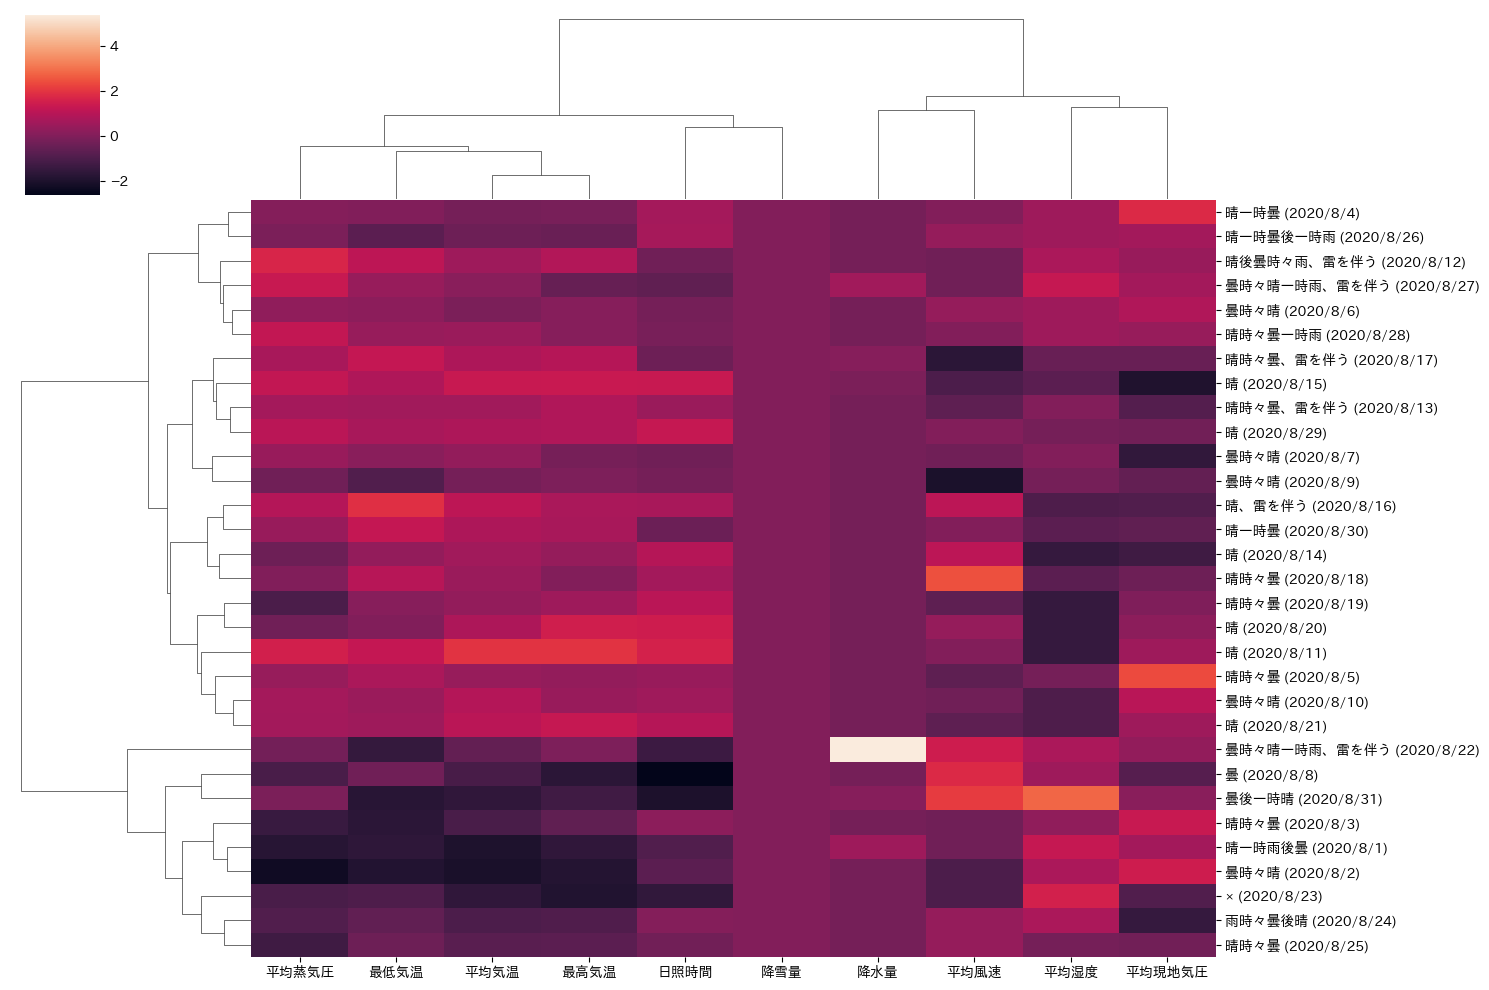

In [ ]:
year = 2020
month = 8
data = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧'] 
target = '天気概況'
weather_data = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                        & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][data].values
weather_target = []
for _day, _target in enumerate(weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                                          & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][target].values):
    weather_target.append(f'{_target} ({year}/{month}/{_day+1})')

# データを標準化
stdsc = StandardScaler()
weather_data = stdsc.fit_transform(weather_data)

# デンドログラムとヒートマップを組み合わせたクラスターマップを出力
# データを標準化 (平均0,分散1に変換)
scaler = StandardScaler()
iris_data_df = scaler.fit_transform(weather_data)
_df = pd.DataFrame(iris_data_df, index=weather_target, columns=data)
sns.clustermap(_df, method='ward', metric='euclidean', figsize=(15, 10))
plt.show()